# Generative Advarsarial Network 

Here is presented the first GAN created by Ian Goodfellow https://arxiv.org/abs/1406.2661

Implementation is done in tensorflow using KERAS API

Created by: Tiago Almeida 13/08/2018

In [37]:
##Reproduceble work
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)


##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization
import tensorflow.keras.backend as K
#tensorflow version when notebook was created - 1.9.0
tf.__version__


'1.9.0'

### Data MNIST

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

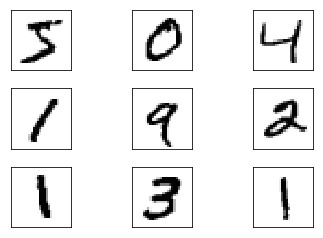

In [38]:
mnist_flat_size = 784

#mnist data

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1,mnist_flat_size]).astype('float32')
x_test = x_test.reshape([-1,mnist_flat_size]).astype('float32')

#rescale the image to [0-1] range
x_train = x_train/ 255
x_test = x_test/ 255

print(x_train[1,:])

print("Shape of the training images",x_train.shape)

ut.plot_mnist_images(x_train[0:9])

#reset graph using during notebook development
K.clear_session()



### Generator network 
In this implementation i use Functional Keras API for creating the network

The network receive a 100-dimensinal vector (z) and return a 784-vector (same size of mnist image (28x28)). The objective is the generator create a mapping between space of vector z and the real MNIST DATA! (i think :P)

TODO: analyse some problems like "mode colapse"

In [39]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense,Activation,LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

#Dimention of random vector using for sampling
z = 100


g_input = Input(shape=[z], name="g_input")
H = Dense(128)(g_input)
H = Activation('relu')(H)
#H = Dense(256)(g_input)
#H = Activation('relu')(H)
H = Dense(mnist_flat_size)(H)
g_output = Activation('sigmoid')(H)
"""
#More advancer network
g_input = Input(shape=[z])
H = Dense(256)(g_input)
H = LeakyReLU(alpha=0.2)(H)
H = BatchNormalization(momentum=0.8)(H)
H = Dense(512)(H)
H = LeakyReLU(alpha=0.2)(H)
H = BatchNormalization(momentum=0.8)(H)
H = Dense(1024)(H)
H = LeakyReLU(alpha=0.2)(H)
H = BatchNormalization(momentum=0.8)(H)
H = Dense(mnist_flat_size)(H)
g_output = Activation('tanh')(H)
"""
generator = Model(g_input,g_output, name="generator")
#No need to compile because he will use train with adversarial method
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


### Discriminator network 

The network receives a image (784 vector) and try classify as fake or original.

In [40]:

d_optimizer = Adam(lr=0.001)


d_input = Input(shape=[mnist_flat_size],  name="d_input")
H = Dense(128)(d_input)
H = Activation('relu')(H)
H = Dense(1)(H)
d_output = Activation('sigmoid')(H)

"""
d_input = Input(shape=[mnist_flat_size],  name="d_input")
H = Dense(512)(d_input)
H = LeakyReLU(alpha=0.2)(H)
H = Dense(128)(H)
H = LeakyReLU(alpha=0.2)(H)
H = Dense(1)(H)
d_output = Activation('sigmoid')(H)
"""
discriminator = Model(d_input,d_output, name="discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer)
discriminator.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


### Adversarial Model

Used to train the generator

In [41]:

def make_trainable(net, val=True):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# Freeze weights in the discriminator for adversarial training
make_trainable(discriminator, False)

gan_optimizer = Adam(lr=0.001)

# Build stacked GAN model to train the generator
gan_input = Input(shape=[z], name="gan_z_input")
gan_fake_samples = generator(gan_input)
gan_output = discriminator(gan_fake_samples)

gan = Model(gan_input, gan_output, name="generator_adversarial")
gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gan_z_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 784)               114064    
_________________________________________________________________
discriminator (Model)        (None, 1)                 100609    
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


### Training Algorithm


Discriminator loss:  0.7541049
Generator loss: 1.8631489


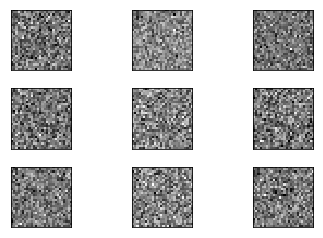

Discriminator loss:  0.01679875
Generator loss: 9.187222


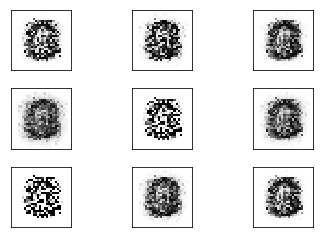

Discriminator loss:  0.029021662
Generator loss: 4.760223


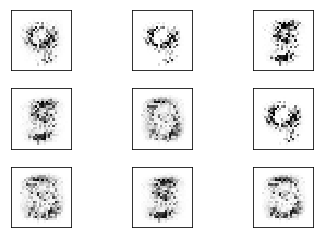

Discriminator loss:  0.040959366
Generator loss: 5.8336835


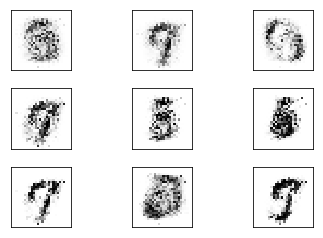

Discriminator loss:  0.06222854
Generator loss: 5.666241


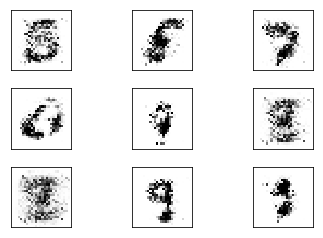

Discriminator loss:  0.3109167
Generator loss: 3.7850218


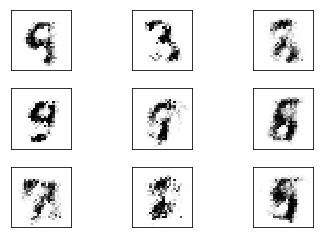

Discriminator loss:  0.2621144
Generator loss: 3.7729034


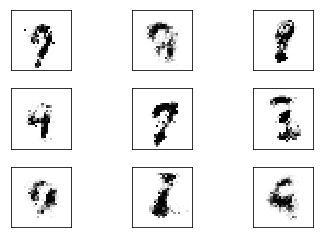

Discriminator loss:  0.32522655
Generator loss: 2.2634232


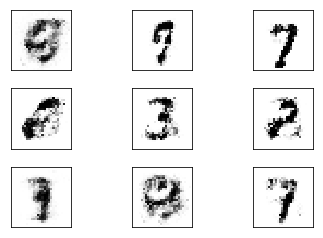

Discriminator loss:  0.37514782
Generator loss: 2.6267035


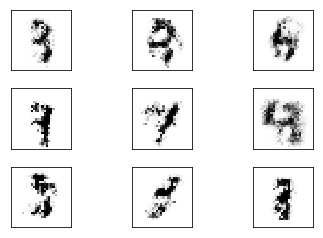

Discriminator loss:  0.45045978
Generator loss: 2.0557106


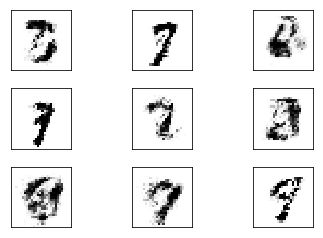

Discriminator loss:  0.36418754
Generator loss: 2.7657268


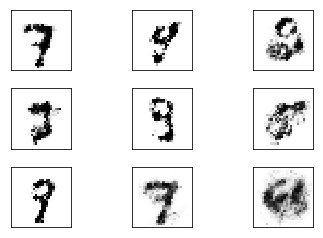

Discriminator loss:  0.41196382
Generator loss: 2.2592726


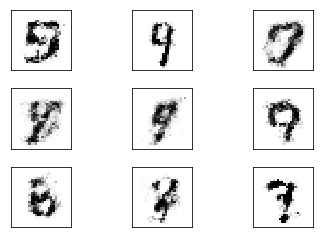

Discriminator loss:  0.39641082
Generator loss: 1.8889163


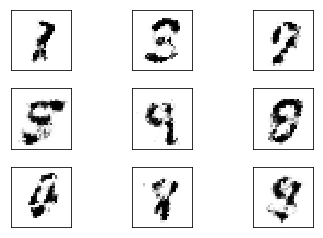

Discriminator loss:  0.4666971
Generator loss: 1.6942052


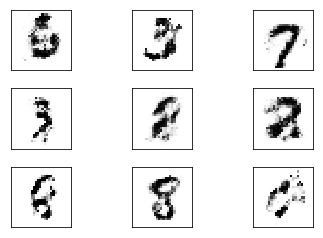

Discriminator loss:  0.47022584
Generator loss: 1.7658871


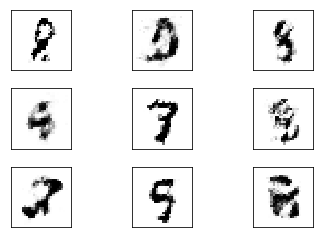

Discriminator loss:  0.3798068
Generator loss: 1.9140103


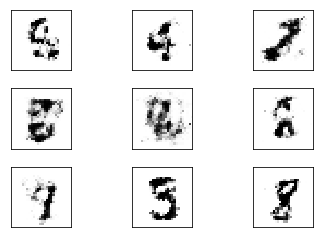

Discriminator loss:  0.42079413
Generator loss: 1.9051476


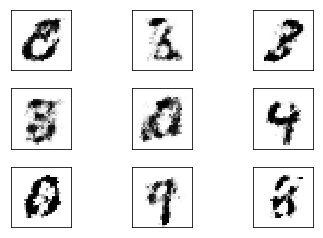

Discriminator loss:  0.4292494
Generator loss: 1.7304394


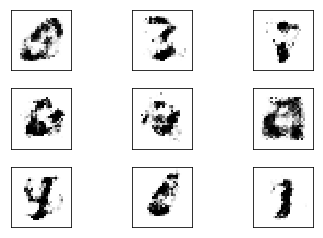

Discriminator loss:  0.48415676
Generator loss: 1.4247056


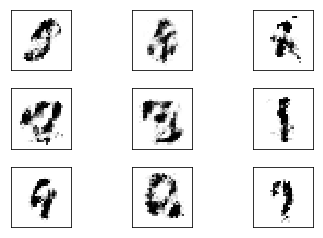

Discriminator loss:  0.48640954
Generator loss: 1.4784399


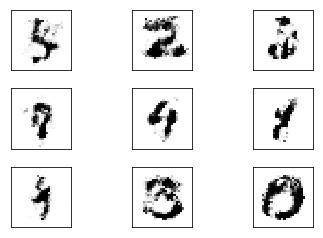

Discriminator loss:  0.412144
Generator loss: 1.561147


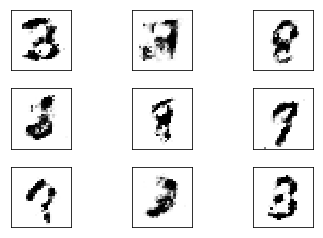

Discriminator loss:  0.4568873
Generator loss: 1.8611492


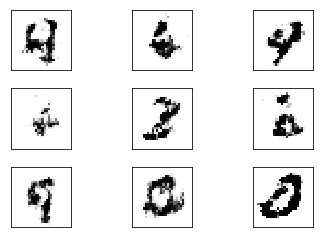

Discriminator loss:  0.4373396
Generator loss: 1.6839089


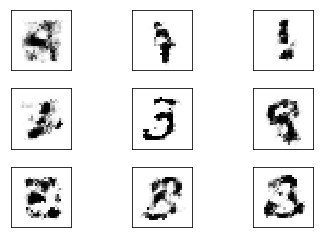

Discriminator loss:  0.47357404
Generator loss: 1.5018184


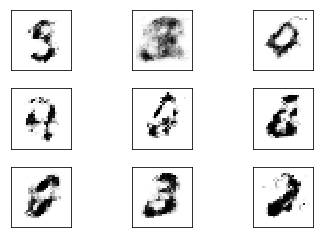

Discriminator loss:  0.40523216
Generator loss: 1.8050056


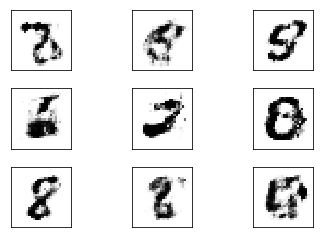

Discriminator loss:  0.41489422
Generator loss: 1.852512


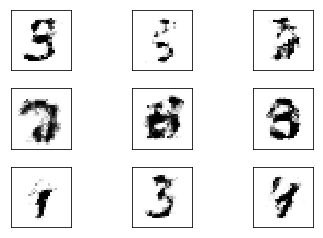

Discriminator loss:  0.45143107
Generator loss: 1.7133133


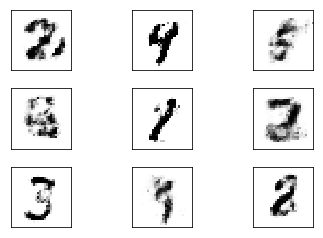

Discriminator loss:  0.43326432
Generator loss: 1.7996129


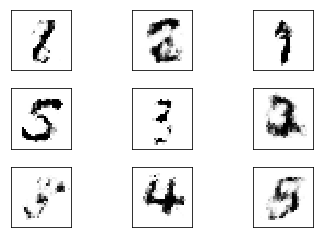

Discriminator loss:  0.50144607
Generator loss: 1.7861673


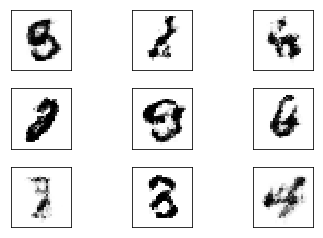

Discriminator loss:  0.46059346
Generator loss: 1.6955462


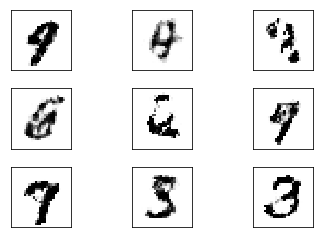

Discriminator loss:  0.5493155
Generator loss: 1.6324562


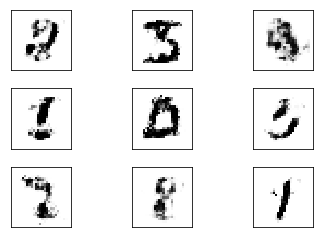

Discriminator loss:  0.44537964
Generator loss: 1.8578442


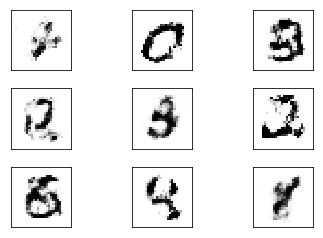

Discriminator loss:  0.53403497
Generator loss: 1.5279217


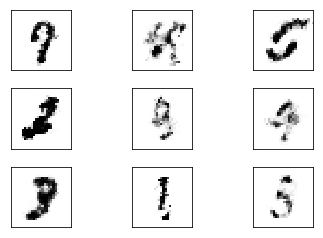

Discriminator loss:  0.43989402
Generator loss: 1.6327168


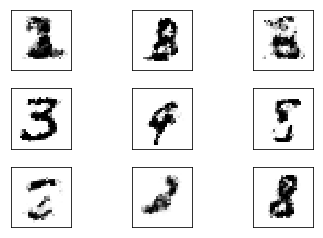

Discriminator loss:  0.41498995
Generator loss: 1.8421533


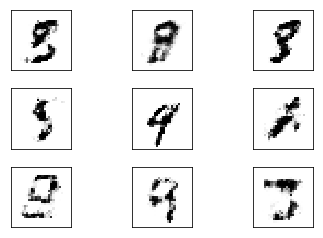

Discriminator loss:  0.4773677
Generator loss: 1.666353


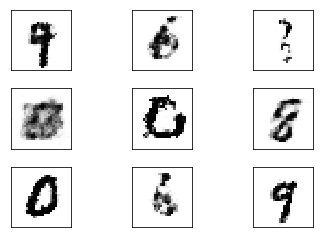

Discriminator loss:  0.41928232
Generator loss: 1.7464361


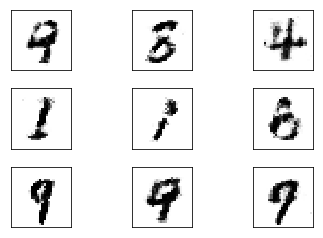

Discriminator loss:  0.41357586
Generator loss: 1.5452439


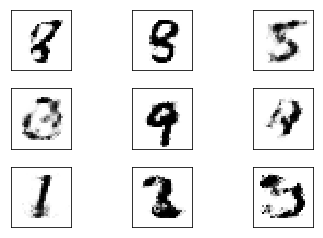

Discriminator loss:  0.42479533
Generator loss: 1.6632997


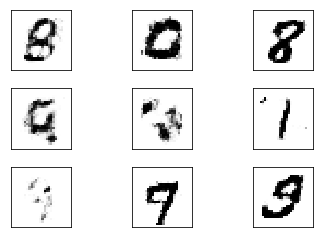

Discriminator loss:  0.43376583
Generator loss: 1.835458


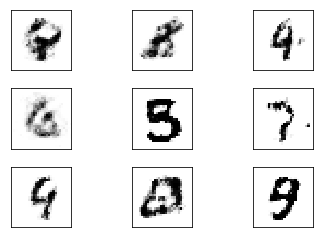

Discriminator loss:  0.38257575
Generator loss: 1.6879897


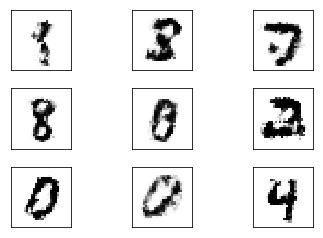

Discriminator loss:  0.4217178
Generator loss: 1.7867887


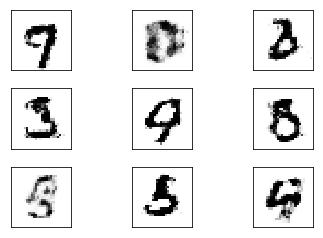

Discriminator loss:  0.47612107
Generator loss: 1.7070147


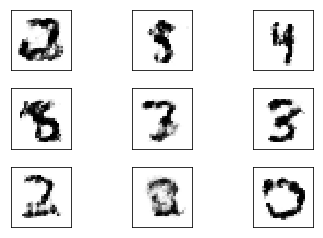

Discriminator loss:  0.38883403
Generator loss: 2.1826124


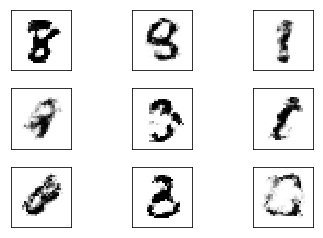

Discriminator loss:  0.46489966
Generator loss: 1.6463552


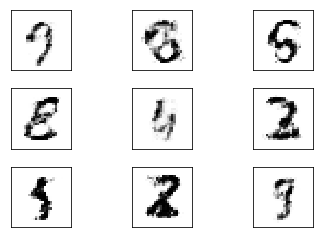

Discriminator loss:  0.42669415
Generator loss: 1.9353217


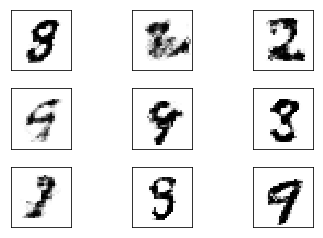

Discriminator loss:  0.44353902
Generator loss: 1.7329679


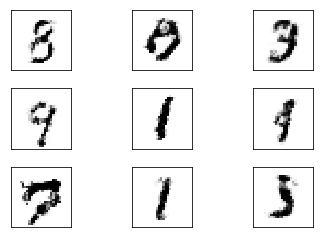

Discriminator loss:  0.4178716
Generator loss: 1.838012


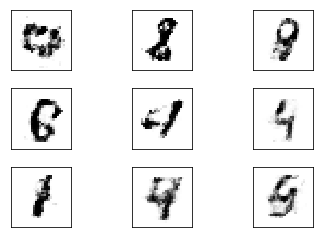

Discriminator loss:  0.47478485
Generator loss: 1.744093


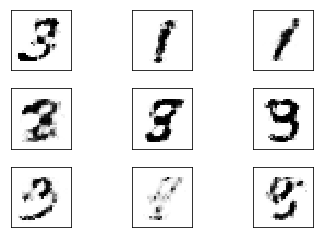

Discriminator loss:  0.40622228
Generator loss: 1.8392527


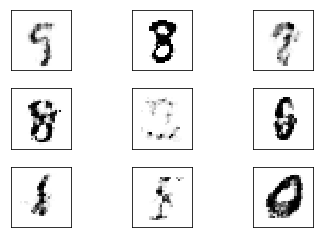

Discriminator loss:  0.34200928
Generator loss: 1.9056032


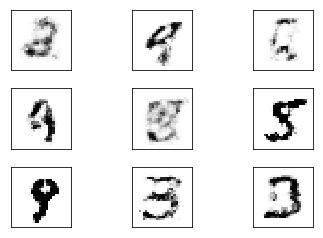

Discriminator loss:  0.39922965
Generator loss: 1.790635


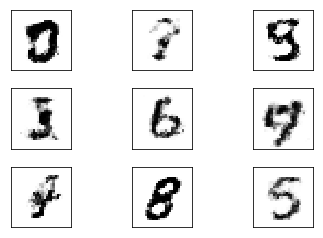

Discriminator loss:  0.41355258
Generator loss: 1.9746356


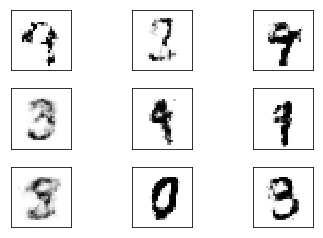

Discriminator loss:  0.41451302
Generator loss: 1.9270961


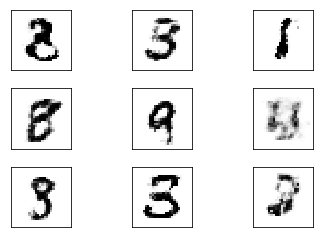

Discriminator loss:  0.3427978
Generator loss: 2.0289063


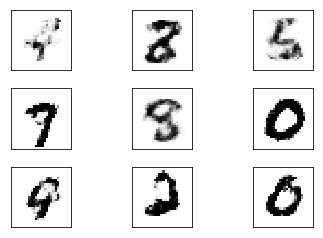

Discriminator loss:  0.47904894
Generator loss: 1.7959706


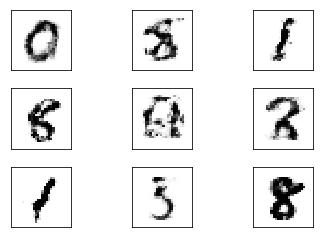

Discriminator loss:  0.397849
Generator loss: 1.8924025


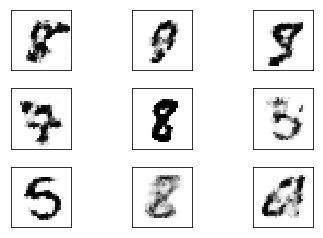

Discriminator loss:  0.40442154
Generator loss: 1.9573534


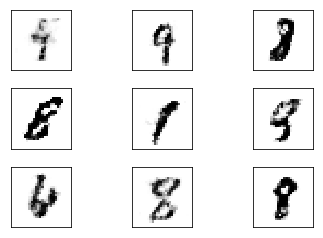

Discriminator loss:  0.47866887
Generator loss: 1.8793621


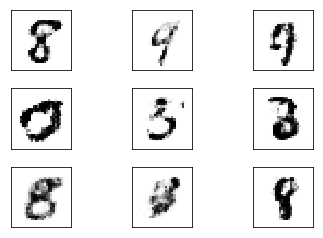

Discriminator loss:  0.38261312
Generator loss: 1.8905637


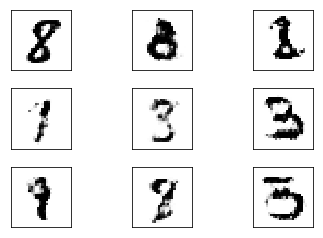

Discriminator loss:  0.42359558
Generator loss: 1.8526335


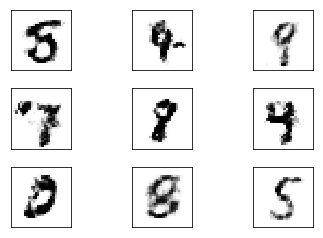

Discriminator loss:  0.39859262
Generator loss: 1.9876097


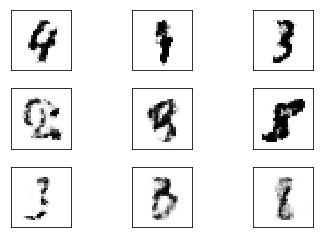

Discriminator loss:  0.38302448
Generator loss: 1.7056131


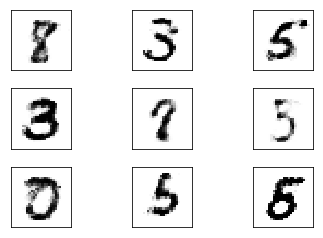

Discriminator loss:  0.39023376
Generator loss: 1.9066815


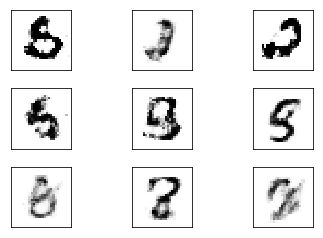

Discriminator loss:  0.34614974
Generator loss: 1.8417954


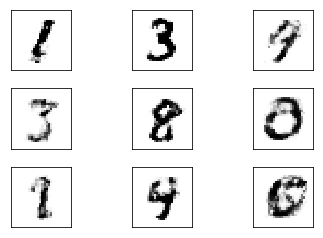

Discriminator loss:  0.33514658
Generator loss: 1.8323709


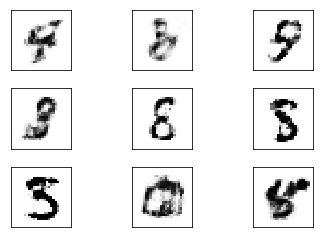

Discriminator loss:  0.3458626
Generator loss: 1.8844702


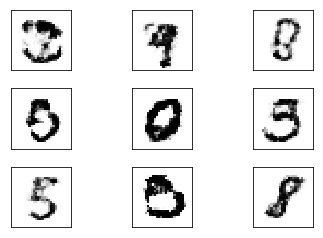

Discriminator loss:  0.3777668
Generator loss: 1.7875184


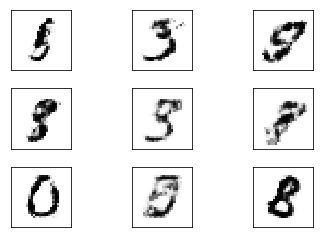

Discriminator loss:  0.3762787
Generator loss: 1.894401


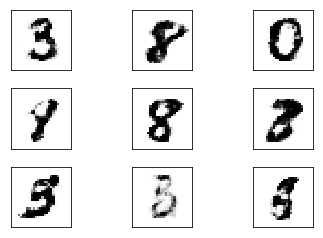

Discriminator loss:  0.3589635
Generator loss: 1.8415432


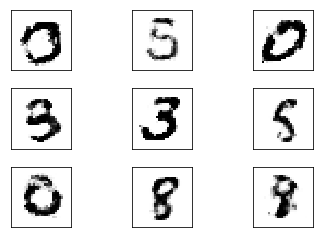

Discriminator loss:  0.42520475
Generator loss: 2.0211358


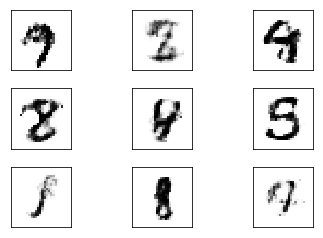

Discriminator loss:  0.39326668
Generator loss: 2.244779


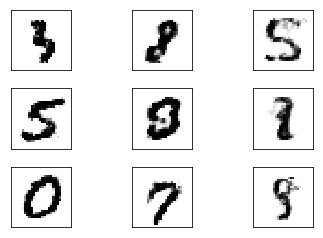

Discriminator loss:  0.31469733
Generator loss: 1.9020952


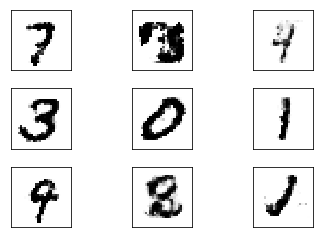

Discriminator loss:  0.42236516
Generator loss: 2.0356722


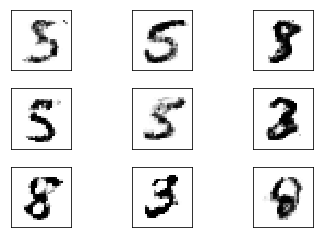

Discriminator loss:  0.44506997
Generator loss: 1.8219335


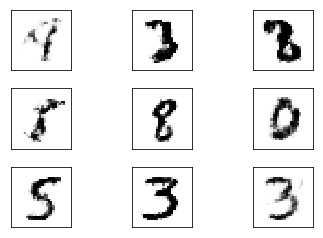

Discriminator loss:  0.361445
Generator loss: 2.1012938


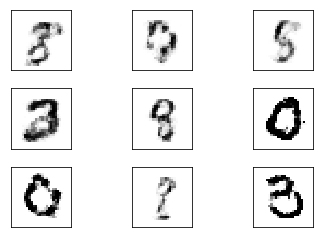


 Plot learning curves 



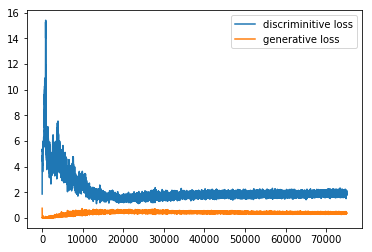

In [42]:
#try shuffle the data
from sklearn.utils import shuffle


def random_Z(m, n=z):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

## Start graph computations and algorithm


batch_size = 256 #must be multiple of 2
epoach = 75000

##check summary again
#make_trainable(discriminator,True)
#discriminator.summary()
#make_trainable(discriminator,False)
#gan.summary()

#save losses 
losses = {}
losses["gan_loss"] = []
losses["d_loss"] = []

for i in range(epoach):
    
    #generate images
    synthetic_images = generator.predict_on_batch(random_Z(batch_size//2))
    #select from tranning set
    real_images = x_train[np.random.randint(0,x_train.shape[0],size=batch_size//2),:]
    
    d_x = np.concatenate((synthetic_images, real_images))
    d_y = np.zeros([batch_size,1])
    
    d_y[batch_size//2:] = 1 #second half of the batch are true images so have label 1 and fake (first half) have label 0
        
    #print("d_x shape",d_x.shape)
    #print("d_y shape",d_y.shape)    
 
    

    #first discriminator
    make_trainable(discriminator,True)
    d_loss = discriminator.train_on_batch(d_x,d_y)
    
    #second generator in adversarail faction
    gan_x = random_Z(batch_size)
    gan_y = np.ones([batch_size,1])
    #print("gan_x shape",gan_x.shape) 
    #print("gan_y shape",gan_y.shape)
    #print(gan_y)
    make_trainable(discriminator,False)
    gan_loss = gan.train_on_batch(gan_x,gan_y)
    
    losses["gan_loss"] += [gan_loss]
    losses["d_loss"] += [d_loss]
    
    print("Epoach",i,end='\r')
    
    if i%1000 == 0:
       
        print("Discriminator loss: ",d_loss)
        print("Generator loss:",gan_loss)

  
        #sample 9 images from generator
        generated_images = generator.predict_on_batch(random_Z(9))
        ut.plot_mnist_images(generated_images)
    
print("Discriminator loss: ",d_loss)
print("Generator loss:",gan_loss)


#sample 9 images from generator
generated_images = generator.predict_on_batch(random_Z(9))
ut.plot_mnist_images(generated_images)

print("\n Plot learning curves \n")

plt.plot(losses["gan_loss"], label='discriminitive loss')
plt.plot(losses["d_loss"], label='generative loss')
plt.legend()
plt.show()


### Analysing noise Z

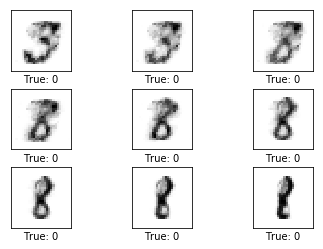